In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
current_path = os.getcwd()
previous_path = os.chdir("..")
sys.path.append(current_path)
sys.path.append(previous_path)

In [2]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from data_fitting.module_fitzcu import *

from qick import *
# for now, all the tProc v2 classes need to be individually imported (can't use qick.*)
# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSpan, QickSweep1D

import json
import datetime
import pprint as pp

In [3]:
import Pyro4
from qick import QickConfig
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

ns_host = "192.168.10.5"
ns_port = 8888
proxy_name = "myqick"

ns = Pyro4.locateNS(host=ns_host, port=ns_port)
soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
print(soccfg)

QICK running on ZCU216, software version 0.2.302

Firmware configuration (built Tue Sep 10 16:13:40 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	16 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 16384 samples (1.709 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 4096 samples (0.427 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 8192 samples (0.855 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 4096 samples (0.427 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_sg_int4_v2 - envelope memory 16384 samples (38.095 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 3

  0%|          | 0/1000 [00:00<?, ?it/s]

pulse freq 5450.000000 MHz, RO freq 5450.000000 MHz, difference 0.000000e+00 MHz
pulse freq 5799.999999 MHz, RO freq 5799.999999 MHz, difference 0.000000e+00 MHz
pulse freq 5900.000000 MHz, RO freq 5900.000000 MHz, difference 0.000000e+00 MHz
pulse freq 5999.999999 MHz, RO freq 5999.999999 MHz, difference 0.000000e+00 MHz
pulse freq 6090.000000 MHz, RO freq 6090.000000 MHz, difference 0.000000e+00 MHz


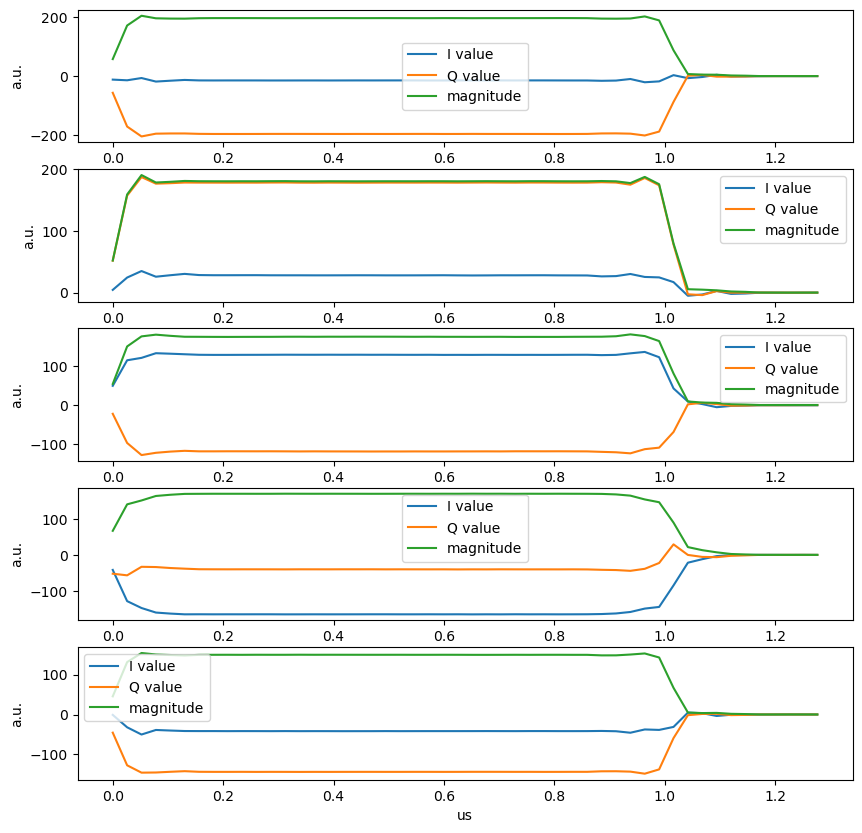

In [4]:
class MixMuxGenMuxROProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_chs = cfg['ro_chs']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=2, ro_ch=ro_chs[0], 
                         mixer_freq=cfg['mixer_freq'],
                         mux_freqs=cfg['pulse_freqs'], 
                         mux_gains=cfg['pulse_gains'],
                         mux_phases=cfg['pulse_phases'])
        
        for ch, f, ph in zip(cfg['ro_chs'], cfg['pulse_freqs'], cfg['ro_phases']):
            self.declare_readout(ch=ch, length=cfg['ro_len'], freq=f, phase=ph, gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="mymux", 
                       style="const", 
                       length=cfg["pulse_len"],
                       mask=[0,1,2,3,4],
                      )
        
    def _body(self, cfg):
        self.trigger(ros=cfg['ro_chs'], pins=[0], t=cfg['trig_time'], ddr4=True)

        self.pulse(ch=cfg['gen_ch'], name="mymux", t=0)
        
config = {'gen_ch': 12,
          'ro_chs': [2, 3, 4, 5, 6],
          'pulse_freqs': [5450, 5800, 5900, 6000, 6090],
          'mixer_freq': 5700,
          'pulse_gains': [1.0]*5,
          'pulse_phases': [0.0]*5,
          'ro_phases': [0.0]*5,
          'trig_time': 0.7,
          'pulse_len': 1.0,
          'ro_len': 1.3,
         }

prog = MixMuxGenMuxROProgram(soccfg, reps=1, final_delay=0.2, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=1000)
t = prog.get_time_axis(ro_index=0)

fig, axes = plt.subplots(len(config['ro_chs']), 1, figsize=(10,10))
for i, ch in enumerate(config['ro_chs']):
    plot = axes[i]
    plot.plot(t, iq_list[i][:,0], label="I value")
    plot.plot(t, iq_list[i][:,1], label="Q value")
    plot.plot(t, np.abs(iq_list[i].dot([1,1j])), label="magnitude")
    plot.legend()
    plot.set_ylabel("a.u.")
    plot.set_xlabel("us");

for i, ch in enumerate(config['ro_chs']):
    # frequency-matching cross-check
    f_gen = prog.gen_chs[config['gen_ch']]['mux_tones'][i]['freq_rounded']
    f_ro = prog.ro_chs[ch]['ro_config']['f_rounded']
    print("pulse freq %f MHz, RO freq %f MHz, difference %e MHz"%(f_gen, f_ro, f_gen-f_ro))

In [ ]:
class MixMuxGenMuxROProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_chs = cfg['ro_chs']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=2, ro_ch=ro_chs[0], 
                         mixer_freq=cfg['mixer_freq'],
                         mux_freqs=cfg['pulse_freqs'], 
                         mux_gains=cfg['pulse_gains'],
                         mux_phases=cfg['pulse_phases'])
        for ch, f, ph in zip(cfg['ro_chs'], cfg['pulse_freqs'], cfg['ro_phases']):
            self.declare_readout(ch=ch, length=cfg['ro_len'], freq=f, phase=ph, gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="mymux", 
                       style="const", 
                       length=cfg["pulse_len"],
                       mask=[0,1,2,3,4,5],
                      )
        
    def _body(self, cfg):
        self.trigger(ros=cfg['ro_chs'], pins=[0], t=cfg['trig_time'], ddr4=True)

        self.pulse(ch=cfg['gen_ch'], name="mymux", t=0)

n_roch=6
config = {'gen_ch': 12,
          'ro_chs': [2,3,4,5,6,7],
          'pulse_freqs': [5710, 5820, 5900, 6000, 6090],
          'mixer_freq': 5850,
          'pulse_gains': [1]*n_roch,
          'pulse_phases': [0.0]*n_roch,
          'ro_phases': [0.0]*n_roch,
          'trig_time': 0.6,
          'pulse_len': 1.0,
          'ro_len': 1.2,
         }

# prog = MixMuxGenMuxROProgram(soccfg, reps=1000, final_delay=0.2, cfg=config)

# iq_list = prog.acquire(soc, soft_avgs=1)
# t = prog.get_time_axis(ro_index=0)

In [ ]:
initial = [5461, 5663, 5775, 5899.4, 6030, 6189]
sweep = np.linspace(-15, 15, 101)
z1=[]
z2=[]
z3=[]
z4=[]
z5=[]
z6=[]
config['pulse_gains'] = [1]*n_roch
for i in tqdm(sweep):
    config['pulse_freqs'] = np.array(initial)+i
    prog = MixMuxGenMuxROProgram(soccfg, reps=2000, final_delay=0.05, cfg=config)
    x1, x2, x3, x4, x5, x6 = prog.acquire(soc, soft_avgs=1, progress=False)
    z1.append(x1[0][0]+1j*x1[0][1])
    z2.append(x2[0][0]+1j*x2[0][1])
    z3.append(x3[0][0]+1j*x3[0][1])
    z4.append(x4[0][0]+1j*x4[0][1])
    z5.append(x5[0][0]+1j*x5[0][1])
    z6.append(x6[0][0]+1j*x5[0][1])

In [ ]:
initial = [5461, 5663, 5775, 5899.4, 6030, 6189]

popt = [[]]*n_roch
res_freq = [[]]*n_roch
x = [z1, z2, z3, z4, z5, z6]
fig, ax = plt.subplots(1, n_roch, figsize=(20,5))
for i in range(n_roch):
    ax[i].plot(initial[i] + sweep, np.abs(x[i]))
    popt[i],_ = fit_asym_lor(initial[i] + sweep, np.abs(x[i]))
    ax[i].plot(initial[i] + sweep, asym_lorfunc(initial[i] + sweep, *popt[i]), label=f'f_res = {popt[i][2]}')
    ax[i].legend(loc='upper right')
    res_freq[i] = round(popt[i][2], 2)
plt.tight_layout()